In [1]:
!pip install labelme tensorflow opencv-python albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.7 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 94.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.4.1-py3-none-any.whl size=1436184 sha256=c2d5ab7d83661a351a5fed145f2cf65e684cd57851b1feb6e174e86bfec0d163
  Stored i

In [2]:
# Import essential libraries for image processing, machine learning, and data handling.
import os
import time
import uuid
import cv2 as cv
import tensorflow as tf
import numpy as np
import tensorflow
import json
import matplotlib.pyplot as plt
import albumentations as alb
import splitfolders
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

2024-04-06 19:39:36.247663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 19:39:36.247775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 19:39:36.374225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Loading model After I have trained it.
# model=tf.keras.models.load_model("/kaggle/input/face_tracker/keras/face_tracker/1/facetracker.keras", compile=False)

In [ ]:
IMAGES_PATH=os.path.join('/kaggle/working/data','my_faces')
number_images=10

In [8]:
!labelme

2024-03-21 21:18:19,459 [INFO   ] __init__:get_config:67- Loading config file from: /root/.labelmerc
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:                                 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.test.is_gpu_available()

True

In [3]:
# Load images from a specified directory and prepare them for processing.

# List all image files in the specified directory.
images = tf.data.Dataset.list_files(r'/kaggle/input/my-face-images/data/images/*.jpg', shuffle=True)

In [4]:
type(images)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [5]:
images.as_numpy_iterator().next()

b'/kaggle/input/my-face-images/data/images/f3c38d25-e7c7-11ee-981c-34f39a7e342e.jpg'

In [6]:
# Function to load an image file and decode it into a usable format.
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

# Apply the load_image function to each file in the dataset.
images = images.map(load_image)

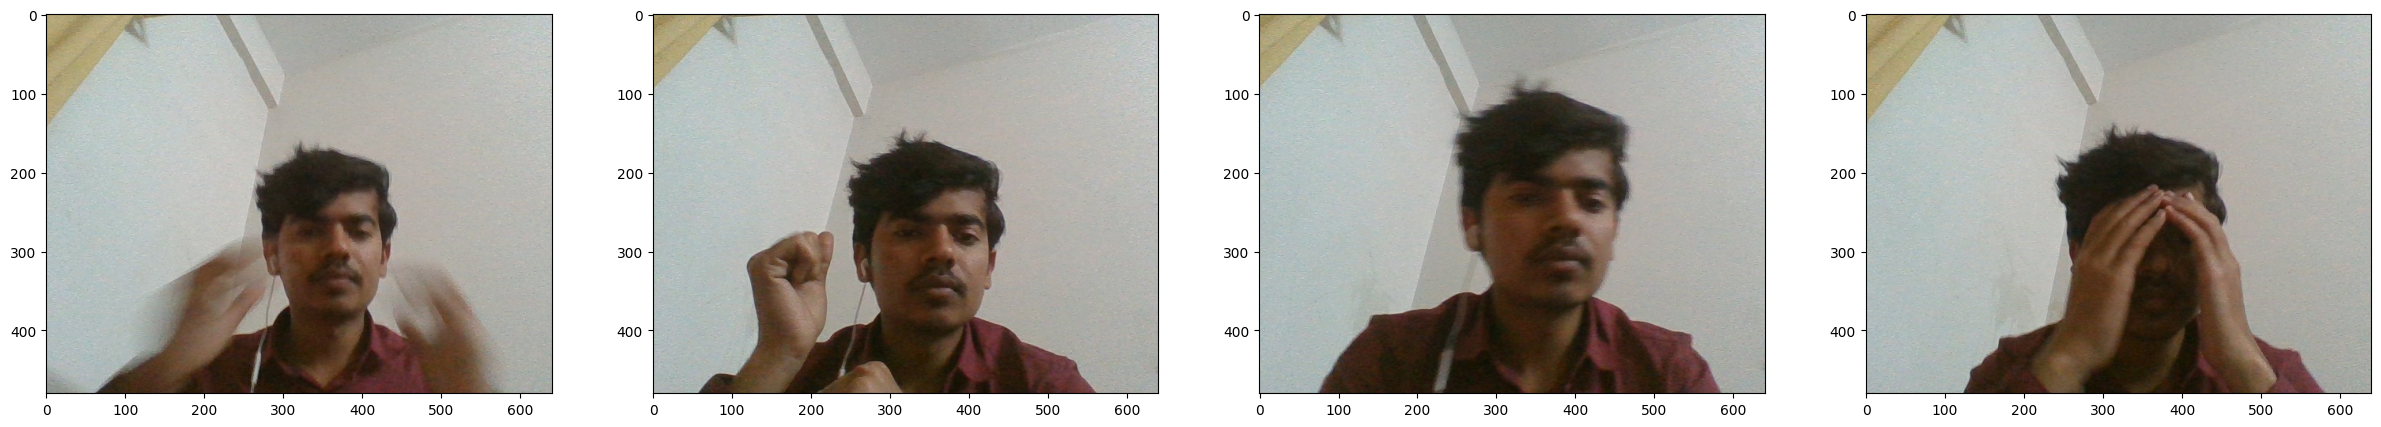

In [12]:
# Display a batch of images from the dataset.

# Generate a batch of 4 images.
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

# Plot the images in a 2x2 grid.
fig, ax = plt.subplots(ncols=4, figsize=(30, 30))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [14]:

# Split the dataset into training, testing, and validation sets using a specified ratio.
splitfolders.ratio("/kaggle/input/my-face-images/data", output="/kaggle/working/data", seed=1337, ratio=(.7, .15, .15))

Copying files: 108 files [00:00, 268.96 files/s]


In [15]:
# Check if there are any mismatched images and labels.

images_folder = "/kaggle/working/data/train/images"
labels_folder = "/kaggle/working/data/train/labels"

# List image and label filenames.
image_filenames = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]
label_filenames = [f for f in os.listdir(labels_folder) if f.endswith('.json')]

# Initialize a list to store mismatches.
mismatches = []

# Check for missing label files corresponding to image files.
for image_filename in image_filenames:
    image_prefix = image_filename.split('.')[0]
    expected_label_filename = image_prefix + '.json'
    if expected_label_filename not in label_filenames:
        mismatches.append(f"Image '{image_filename}' is missing a corresponding label file.")

# Check for missing image files corresponding to label files.
for label_filename in label_filenames:
    label_prefix = label_filename.split('.')[0]
    expected_image_filename = label_prefix + '.jpg'
    if expected_image_filename not in image_filenames:
        mismatches.append(f"Label '{label_filename}' is missing a corresponding image file.")

# Print mismatches, if any.
if mismatches:
    print("Found mismatches:")
    for mismatch in mismatches:
        print(mismatch)
else:
    print("All image files have corresponding label files and vice versa.")

All image files have corresponding label files and vice versa.


In [ ]:
# Load and augment a sample image for visualization.

# Load a sample image and its corresponding label.
img = cv.imread('/kaggle/working/data/train/images/ecc5c5e4-e7c7-11ee-b0d3-34f39a7e342e.jpg')
label_path = '/kaggle/working/data/train/labels/ecc5c5e4-e7c7-11ee-b0d3-34f39a7e342e.json'

# Load the label file.
with open(label_path, 'r') as f:
    label = json.load(f)

# Extract coordinates from the label and normalize them.
coords = [label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][0][1],
          label['shapes'][0]['points'][1][0], label['shapes'][0]['points'][1][1]]
coords = list(np.divide(coords, [640, 480, 640, 480]))

# Define augmentation transformations using albumentations.
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

# Apply augmentations.
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [29]:
coords

[0.3948317307692307,
 0.37293956043956045,
 0.6893028846153847,
 0.7873168498168498]

In [33]:
augmented

{'image': array([[[137, 143, 138],
         [141, 146, 144],
         [136, 141, 139],
         ...,
         [179, 180, 176],
         [183, 182, 178],
         [185, 184, 180]],
 
        [[158, 165, 158],
         [146, 152, 147],
         [149, 153, 148],
         ...,
         [182, 183, 179],
         [185, 184, 180],
         [185, 184, 180]],
 
        [[174, 179, 170],
         [151, 155, 149],
         [146, 150, 145],
         ...,
         [180, 181, 177],
         [180, 181, 177],
         [181, 182, 178]],
 
        ...,
 
        [[178, 179, 169],
         [173, 177, 166],
         [173, 177, 166],
         ...,
         [ 45,  43,  85],
         [ 46,  42,  83],
         [ 47,  42,  81]],
 
        [[178, 179, 170],
         [178, 179, 170],
         [176, 177, 168],
         ...,
         [ 45,  43,  85],
         [ 46,  42,  83],
         [ 50,  45,  84]],
 
        [[182, 183, 174],
         [176, 177, 168],
         [176, 177, 168],
         ...,
         [ 52,  50,

In [35]:
augmented['bboxes']

[(0.3704273504273504,
  0.38002442002442005,
  0.7892307692307693,
  0.8220268620268619)]

In [36]:
img.shape

(480, 640, 3)

In [37]:
coords

[0.3948317307692307,
 0.37293956043956045,
 0.6893028846153847,
 0.7873168498168498]

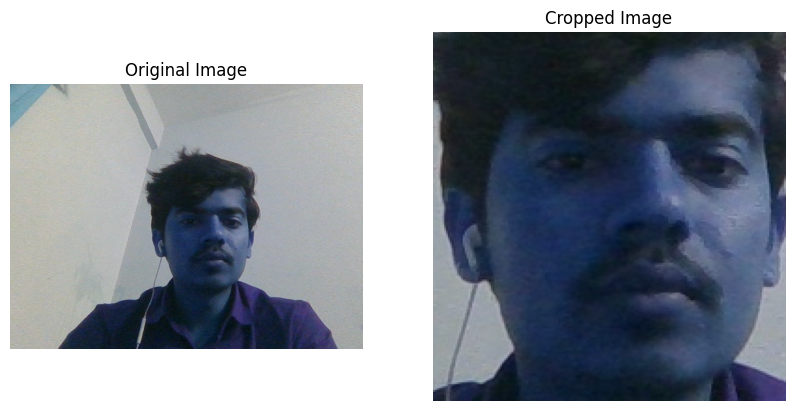

In [39]:
# Plot the original and augmented images for comparison.

# Create a subplot with 2 columns.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image.
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the cropped part of the image using the coordinates from the label.
crop_img = img[int(coords[1]*480):int(coords[3]*480), int(coords[0]*640):int(coords[2]*640)]
axs[1].imshow(crop_img)
axs[1].set_title('Cropped Image')
axs[1].axis('off')

# Show the plot.
plt.show()

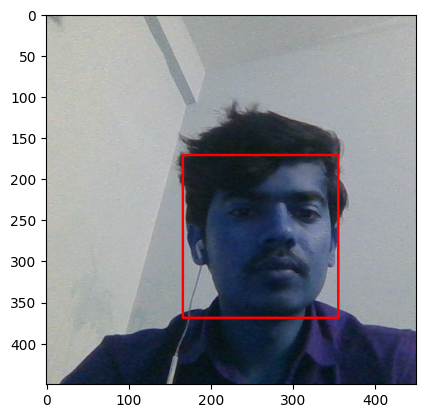

In [41]:
# Draw a rectangle around the augmented bounding box on the augmented image.
cv.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

# Display the augmented image with the bounding box.
plt.imshow(augmented['image'])
plt.show()

In [43]:
# Augment and save data for training, testing, and validation partitions.

# Loop through each partition (train, test, val).
for partition in ['train', 'test', 'val']:
    # Loop through each image in the partition's images folder.
    for image in os.listdir(os.path.join('/kaggle/working/data', partition, 'images')):
        img = cv.imread(os.path.join('/kaggle/working/data', partition, 'images', image))
        coords = [0, 0, 0.00001, 0.00001]  # Default coordinates if label file is missing.

        # Construct the corresponding label file path.
        label_path = os.path.join('/kaggle/working/data', partition, 'labels', f'{image.split(".")[0]}.json')

        # If the label file exists, load it and extract the coordinates.
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords = [label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][0][1],
                      label['shapes'][0]['points'][1][0], label['shapes'][0]['points'][1][1]]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        # Try to augment the image and save the augmented data.
        try:
            for x in range(60):  # Generate 60 augmented samples per image.
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                # Save the augmented image.
                cv.imwrite(os.path.join('/kaggle/working/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                # Prepare the annotation for the augmented image.
                annotation = {'image': image}
                if len(augmented['bboxes']) == 0:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0
                else:
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
                
                # Create directories for augmented images and labels if they don't exist.
                images_dir = os.path.join('/kaggle/working/aug_data', partition, 'images')
                labels_dir = os.path.join('/kaggle/working/aug_data', partition, 'labels')
                os.makedirs(images_dir, exist_ok=True)
                os.makedirs(labels_dir, exist_ok=True)
                
                # Save the augmented label file.
                with open(os.path.join('/kaggle/working/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

[326.86813186813185, 174.6153846153846, 493.90109890109886, 388.90109890109886]
Expected x_min for bbox [326.86813186813185, 174.6153846153846, 493.90109890109886, 388.90109890109886, 'face'] to be in the range [0.0, 1.0], got 326.86813186813185.
[498.8461538461538, 261.4285714285714, 618.6263736263736, 431.2087912087912]
Expected x_min for bbox [498.8461538461538, 261.4285714285714, 618.6263736263736, 431.2087912087912, 'face'] to be in the range [0.0, 1.0], got 498.8461538461538.
[271.3736263736264, 244.94505494505495, 436.75824175824175, 408.1318681318681]
Expected x_min for bbox [271.3736263736264, 244.94505494505495, 436.75824175824175, 408.1318681318681, 'face'] to be in the range [0.0, 1.0], got 271.3736263736264.
[274.12087912087907, 185.05494505494505, 438.9560439560439, 407.5824175824176]
Expected x_min for bbox [274.12087912087907, 185.05494505494505, 438.9560439560439, 407.5824175824176, 'face'] to be in the range [0.0, 1.0], got 274.12087912087907.
[259.2857142857142, 230.

In [180]:
# Define a function to prepare datasets for model training and evaluation.

def prepare_dataset(folder):
    # Load image files from the specified folder.
    images = tf.data.Dataset.list_files(os.path.join(folder, 'images/*.jpg'), shuffle=False)
    images = images.map(load_image)
    return images

# Load and preprocess training, validation, and test datasets.
train_images = prepare_dataset('/kaggle/working/aug_data/train')
val_images = prepare_dataset('/kaggle/working/aug_data/val')
test_images = prepare_dataset('/kaggle/working/aug_data/test')


In [185]:
def load_labels(label_path):
    """Loads class and bounding box labels from a JSON file."""
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [186]:
def create_label_dataset(path_pattern):
    """Creates a TensorFlow dataset for labels from a given file path pattern."""
    label_dataset = tf.data.Dataset.list_files(path_pattern, shuffle=False)
    label_dataset = label_dataset.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
    return label_dataset

# Prepare train, test, and validation label datasets
train_labels = create_label_dataset('/kaggle/working/aug_data/train/labels/*.json')
test_labels = create_label_dataset('/kaggle/working/aug_data/test/labels/*.json')
val_labels = create_label_dataset('/kaggle/working/aug_data/val/labels/*.json')

# Verify the first loaded label
print(train_labels.as_numpy_iterator().next())

In [190]:
# Check the number of samples in each dataset
print(len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels))

(2160, 2160, 540, 540, 420, 420)

In [191]:
def prepare_dataset(images, labels, shuffle_buffer, batch_size):
    """Prepares a TensorFlow dataset by zipping images and labels, shuffling, batching, and prefetching."""
    dataset = tf.data.Dataset.zip((images, labels))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets for training, testing, and validation
train = prepare_dataset(train_images, train_labels, shuffle_buffer=5000, batch_size=8)
test = prepare_dataset(test_images, test_labels, shuffle_buffer=1300, batch_size=8)
val = prepare_dataset(val_images, val_labels, shuffle_buffer=1000, batch_size=8)


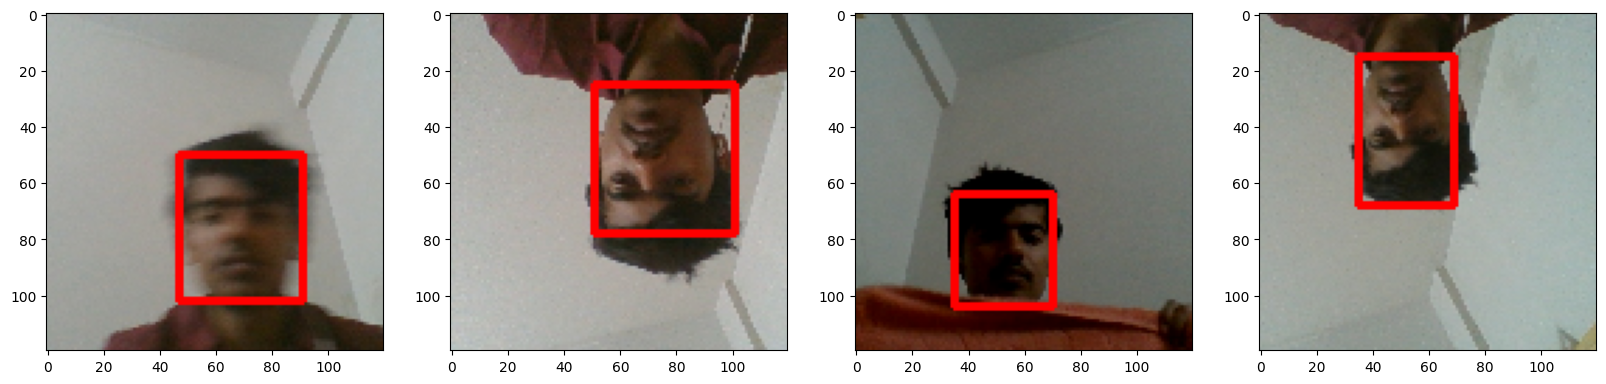

In [197]:
def display_sample_images(dataset):
    """Displays a batch of images with bounding boxes from the given dataset."""
    data_samples = dataset.as_numpy_iterator()
    res = data_samples.next()

    fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
    for idx in range(4):
        sample_image = res[0][idx].copy()
        sample_coords = res[1][1][idx].copy()

        # Draw bounding boxes on the images
        cv.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                     (255, 0, 0), 2)

        ax[idx].imshow(sample_image)
    plt.show()

# Display a sample batch of training images
display_sample_images(train)


In [198]:
def build_model():
    """Builds the FaceTracker model using VGG16 for feature extraction and adding custom classification and regression heads."""
    input_layer = Input(shape=(120, 120, 3))

    # Use VGG16 for feature extraction
    vgg = VGG16(include_top=False)(input_layer)

    # Classification branch
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box regression branch
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Combine the two branches into one model
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

# Build and summarize the model
vgg_model = build_model()
vgg_model.summary()

In [138]:
len(train)

270

In [200]:
# facetracker = build_model()
# facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = vgg_model.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


W0000 00:00:1711233971.237373      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(array([[2.7414464e-19],
        [5.2567297e-01],
        [3.3321719e-08],
        [2.1311289e-05],
        [6.3362210e-12],
        [1.1791381e-02],
        [1.1160321e-07],
        [3.2717719e-18]], dtype=float32),
 array([[4.3254034e-04, 9.9965060e-01, 9.7136712e-01, 1.5149451e-03],
        [9.7683585e-01, 4.4777953e-14, 9.3941722e-15, 3.9754236e-06],
        [9.9962938e-01, 7.6865952e-08, 7.7894430e-10, 1.9718537e-02],
        [9.9958378e-01, 7.7380285e-02, 5.8929872e-20, 9.9999845e-01],
        [9.9067083e-09, 9.9982721e-01, 9.9967873e-01, 9.9709189e-01],
        [8.3731249e-04, 9.9999988e-01, 1.0000000e+00, 9.3642414e-01],
        [9.9968266e-01, 4.8101039e-05, 4.2559091e-06, 2.1313810e-05],
        [3.9106233e-08, 1.0000000e+00, 9.9620003e-01, 1.0000000e+00]],
       dtype=float32))

In [100]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [102]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [4]:
# Working with custom loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [202]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [203]:
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=15.393868>

In [213]:
class FaceTracker(Model):
    """Custom model class for training and evaluating the FaceTracker model."""
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        """Compiles the model with the given optimizer and loss functions."""
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        """Performs a single training step."""
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        """Performs a single evaluation step."""
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        """Calls the model on new inputs."""
        return self.model(X, **kwargs)

# Instantiate and compile the model
model = FaceTracker(vgg_model)
model.compile(opt, classloss, regressloss)

In [78]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])
hist.history

{'total_loss': [0.06688008457422256,
  0.06984882801771164,
  0.031118575483560562,
  0.02145746350288391,
  0.014838491566479206,
  0.009049073792994022,
  0.014490842819213867,
  0.007377596106380224,
  0.007987882941961288,
  0.0094603905454278],
 'class_loss': [0.0008147786720655859,
  0.000952764181420207,
  0.000676195602864027,
  6.436663534259424e-05,
  3.1845367630012333e-05,
  5.081358722236473e-06,
  1.7494478015578352e-05,
  6.030196891515516e-05,
  0.00011999228445347399,
  1.8418288163957186e-05],
 'regress_loss': [0.06647269427776337,
  0.06937244534492493,
  0.030780477449297905,
  0.0214252807199955,
  0.014822568744421005,
  0.009046533145010471,
  0.014482095837593079,
  0.007347445003688335,
  0.00792788714170456,
  0.009451181627810001],
 'val_total_loss': [0.8617666959762573,
  0.04437984153628349,
  0.42737603187561035,
  0.05262139067053795,
  0.09659913927316666,
  0.06672254204750061,
  0.03384046256542206,
  0.02882321923971176,
  0.014894731342792511,
  0.05

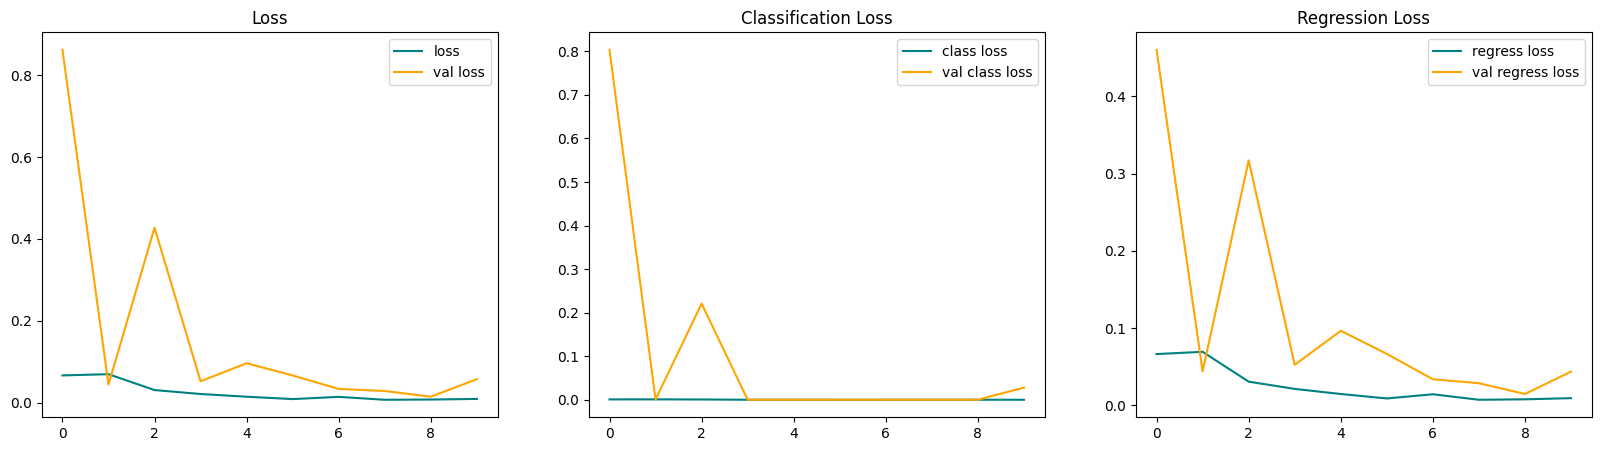

In [79]:
# Plot the training history
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Evaluating the model

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [117]:
yhat = vgg_model.predict(test_sample[0])

1/1 [==============================] - 0s 22ms/step


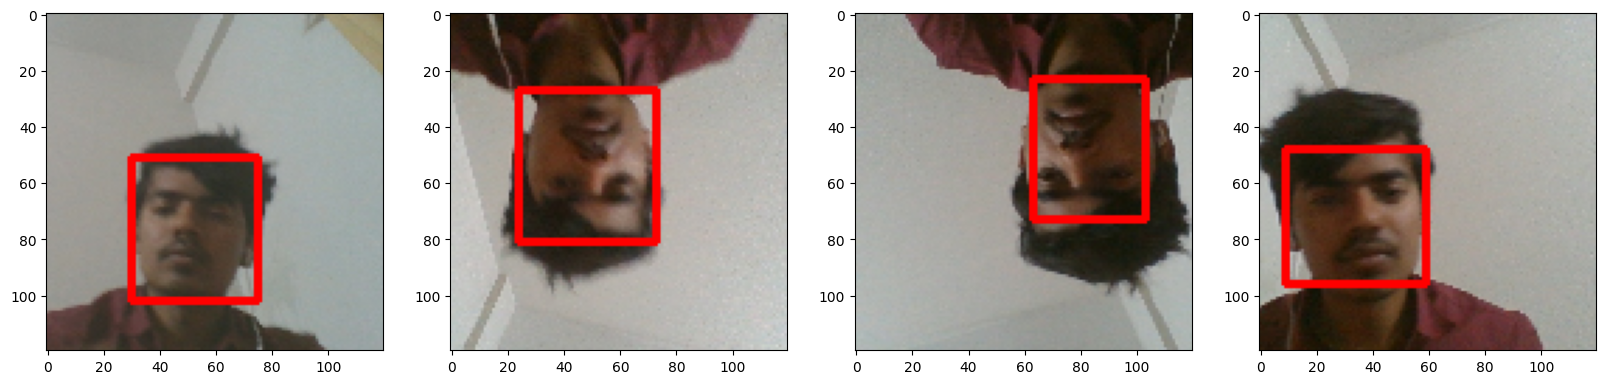

In [118]:
## Looking Good for the very little model.
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx].copy()
    
    if yhat[0][idx] > 0.9:
        cv.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [42]:
os.makedirs('/kaggle/working/models',exist_ok=True)

In [ ]:
from tensorflow import keras

# Load the trained model.
model = keras.models.load_model('/kaggle/input/face_tracker/keras/face_tracker/1/facetracker.keras') 

